# Capstone Project 2: Creating a Recommendation System for DJ Mixes using a Spotify User's preferences

## TOC:
* [1. Introduction](#1.-Introduction)
    * [1.1 Data Source and Importation](#1.1-Data-Source-and-Importation)
    * [1.2 Data Cleaning (Spotify)](#1.2-Data-Cleaning-(Spotify))
    * [1.3 Data Cleaning (1001tracklists.com)](#1.3-Data-Cleaning-(1001tracklists.com))
    * [1.4 Combining Datasets](#1.4-Combining-Datasets)
* [2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)
    * [2.1 Genre Differences in Sets/Mixes](#2.1-Genre-Differences-in-Sets/Mixes)
    * [2.2 Relationship between Spotify Metrics](#2.2-Relationship-between-Spotify-Metrics)
* [3. Recommendation Engine Building](#3.-Recommendation-Engine-Building)
    * [3.1 Artist Similarity Score](#3.1-Artist-Similarity-Score)
    * [3.2 Song Similarity Score](#3.2-Song-Similarity-Score)
    * [3.3 Set/Mix Popularity Score](#3.3-Set/Mix-Popularity-Score)
    * [3.4 Audio Feature Similarity Score](#3.4-Audio-Feature-Similarity-Score)
* [4. Conclusion](#4.-Conclusion)
    * [4.1 Results and Next Steps](#4.1-Results-and-Next-Steps)

# 1. Introduction

I love being recommended and recommending new songs & artists to friends. But in today’s data-driven world, recommendation engines control the new content we see and hear. Whether it be a new product on Amazon, a new show on Netflix, or a new song in your discover weekly Spotify playlist, recommendation engines may know you better than anyone else. 

Let’s take a look at Spotify’s Discover Weekly feature as an example of a recommendation algorithm. It combines various methods, including content-based filtering methods, which looks at the raw audio features of a song to recommend new songs that are similar to songs you’ve listened to and liked before. A closer exploration of Spotify’s recommendation algorithm can be found here: https://medium.com/datadriveninvestor/behind-spotify-recommendation-engine-a9b5a27a935

Yet even with Spotify’s Discover Weekly feature, there aren’t any good recommendation systems for sets/mixes. When it comes to electronic music, I love recommending sets/mixes rather than individual songs because I believe they can more accurately convey the artist’s style. For example, an artist might play unreleased edits, IDs (i.e. unidentifiable songs, typically consisting of an unreleased song by the artist or an artist with a similar style), and play a myriad of songs ranging from their entire discography rather their most recent album. The set/mix might also include some mixing techniques (i.e. transitioning from one song to another) or other live elements that you won’t hear by streaming an individual song. Often times, it’s a combination of these additional “elements” to a set/mix that I want to recommend…and today’s recommendation engines simply don’t have the means to capture this type of data and recommend a set/mix. 

For my 2nd Capstone Project, I try to solve for this by utilizing content-based filtering and collaborative filtering methods to create a recommendation algorithm for sets/mixes. For this, I will need data on both a user’s music preferences and relevant data for sets/mixes. The biggest pitfall today is the lack of available data on sets/mixes and the ability to stream the actual set/mix itself. To combat this, I use Spotify’s Web API to pull a user’s top artists and created an automated-web scraper that searches for a Spotify user’s top artists on a 3rd party website that lists the artist’s most recent sets/mixes and the individual songs played in each set/mix along with other relevant metadata about the set/mix itself. 
* Problem: Creating a recommendation engine for sets/mixes using a Spotify user’s preferences and data scraped from 3rd party resources
* Dataset: Data queried from Spotify’s Web API, data scraped from 1001tracklist.com


# 1.1 Data Source and Importation

The data needed to build an effective recommendation system includes two kinds of inputs: data on **users** and data on **items**:

### Users: Spotify Users
* **Dataset Description**: JSON Objects containing a Spotify User’s top songs, top artists, and saved songs pulled directly from Spotify
* **Dataset Source**: Spotify’s Web API

### Items: Sets/Mixes
* **Dataset Description**: Dataframe containing up to 30 of the most recent sets/mixes played by the Spotify user’s top electronic artists with relevant metrics such as total views, total likes, individual songs played, genres, artists of other songs played, location, etc.
* **Dataset Source**: Data scraped via a custom-built automated web-scraper utilizing Selenium and BeautifulSoup on a 3rd party website that incentivizes users to list and identify songs played in a set/mix



# 1.2 Data Cleaning (Spotify)

### Overview of Spotify's Web API

To access a Spotify user’s music preferences, one must create and register an app and request authorization from both Spotify and the user

![title](SpotifyPic1.png)
![title](SpotifyPic2.png)

The diagrams above illustrate how a API call was processed to access user data. 

For the purposes of this report, the following should be noted:
* Different databases accessed via different scopes: Since we are accessing a Spotify User’s top songs, top artists, and saved songs as inputs to our recommendation engine, the following scopes were specified in our API call:
    * User-library-read
    * User-top-read

<table><tr>
<td> <img src="SpotifyPic3.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="SpotifyPic4.png" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

### Example API Request using my Spotify Account

For this report, I will use my personal Spotify data to illustrate how a Spotify user's data will be accessed:

In [1]:
#Importing other necessary packages
import os.path
import sys
import pandas as pd

#Importing from spotify script - spotifyxx_v4 outputs a quick summary of what I've been listening to on Spotify
from spotifyxx_v4 import *

#printing my top artists and some associated metadata
for item in topArtists['artists']['items']:
    print(item['name'])
    print(item['genres'])
    print(item['popularity'])
    print(item['followers']['total'])

Blame (NGHTMRE Remix) - Ekali
Forever (feat. Elohim) - Ekali
Helios - Ekali
Forever (feat. Elohim) - Laxcity Remix - Ekali
R U I N - Ekali
Jundo - Ekali
Forgot How To Dream (feat. K.Flay) - Ekali
Babylon (feat. Denzel Curry) - Skrillex & Ronny J Remix - Ekali
Babylon (feat. Denzel Curry) - Ekali
Leaving (feat. Yuna) - Ekali
Blame - Ekali
Take a Walk - Passion Pit
Sleepyhead - Passion Pit
thank u, next - Ariana Grande
break up with your girlfriend, i'm bored - Ariana Grande
7 rings - Ariana Grande
Everything (feat. RIA) - Rusty Hook
X / Love - Hex Cougar
No Friend Zone - VAVO
F8 - DELAY.
0 Lake Placid OZZIE
1 Blame Ekali
2 XILLA! MEMBA
3 Golden Fur Elfkowitz
4 Splitting The Atom Massive Attack
5 Hotbox Liquid Stranger
6 Affirmative Action Nas
7 Little Dark Age MGMT
8 Soul to Seoul TOKiMONSTA
9 Sleepyhead Passion Pit
10 Me & You OZZIE
11 Garde Le Pour Toi Paradis
12 Xtra Hucci
13 Tonight Kidswaste
14 WHEN I WAS OLDER - Music Inspired By The Film ROMA Billie Eilish
15 In Your Head - RL Gr

### Getting Unique List of Songs, Artists, and Audio Features of Songs

I first created dictionaries for Artists and Songs with the following keys:

#### Artist Dictionary

In [2]:
artist_dict = {
        "artist_name": "",
        "artist_genre": "",
        "artist_popularity": 0,
        "artist_followers": 0,
}

#### Song Dictionary

In [3]:
song_features = {
        "key": 0,
        "mode": 0,
        "time_signature": 0,
        "acousticness": 0,
        "danceability": 0,
        "energy": 0,
        "loudness": 0,
        "tempo": 0,
        "id": "",
        "uri": "",
        "instrumentalness": 0,
        "valence": 0,
        "name": "",
}

#### Dataframes

I then converted each dictionary into a dataframe. 

In [4]:
print(topArtists_DF.head())
print(top_songs_DF.head())
print(saved_songs_DF.head())
print(songFeatures_DF.head())

   artist_followers                                       artist_genre  \
0          19343461                                              [pop]   
1             54547  [brostep, electro house, electronic trap, moom...   
2            165177  [aussietronica, australian electropop, austral...   
3             79314  [bass trap, brostep, canadian electronic, edm,...   
4            104698            [emo, neon pop punk, pop emo, pop punk]   

  artist_name  artist_popularity  EDM_Artist  
0    Maroon 5                 88       False  
1          4B                 54       False  
2  Peking Duk                 63        True  
3       Ekali                 60        True  
4    Go Radio                 52       False  
      song_artist                 song_id           song_name
0           OZZIE  089mwkU2EXDpGgWGJvRRWp         Lake Placid
1           Ekali  089tprIgsyFSOrZpugamLI               Blame
2           MEMBA  0XuLNUkcJdxiG2Jx5YRIUM              XILLA!
3       Elfkowitz  0ZXWBh

Since the recommendation engine is using data for sets/mixes from 1001tracklists.com, I also flag if an artist has an "electronic" genre because 1001tracklists.com is primarily focused on electronic music.

In [5]:
#Flagging artist if artist is an EDM artist
topArtists_DF["EDM_Artist"] = topArtists_DF["artist_genre"].map(lambda x: "edm" in x)
edmArtists_DF = topArtists_DF.loc[(topArtists_DF["EDM_Artist"] == True)]

In [6]:
print(topArtists_DF)

    artist_followers                                       artist_genre  \
0           19343461                                              [pop]   
1              54547  [brostep, electro house, electronic trap, moom...   
2             165177  [aussietronica, australian electropop, austral...   
3              79314  [bass trap, brostep, canadian electronic, edm,...   
4             104698            [emo, neon pop punk, pop emo, pop punk]   
5             485890  [edm, electro house, electronic trap, pop, pop...   
6            7161555      [dance pop, edm, miami hip hop, pop, pop rap]   
7              32580  [bass trap, brostep, electro house, electronic...   
8               2397                                                 []   
9             193113  [brostep, edm, electro house, electronic trap,...   
10              1238                                                 []   
11            958027                          [edm, electro house, pop]   
12             22780     

In [7]:
#Creating unique list of edm artists to search with selenium on 1001tracklists.com
unique_edmArtists = []
unique_edmArtists = list(edmArtists_DF["artist_name"])

In [8]:
print(unique_edmArtists)

['Peking Duk', 'Ekali', 'San Holo', 'Flo Rida', 'Ookay', 'Jack Ü', 'Jai Wolf', 'JOYRYDE', 'Flosstradamus']


For the purposes of this report, I look at random artists in my top EDM Artists I listen to. The artists I look at in this report include:
* Ekali
* San Holo
* JOYRYDE
* Flosstradamus

# 1.3 Data Cleaning (1001tracklists.com)

### Overview of 1001tracklists.com

1001tracklist.com is a 3rd party resource where users provide a link to the actual set/mix (e.g. Youtube link, Soundcloud link, Mixcloud link, etc.) and list out the artists and name of the individual songs played in the set/mix. Other relevant metadata that was scraped include total webpage views, date played, total set/mix likes, genres, duration of each individual song, number of individual songs played and number of songs actually identified.

Shown below is an example webpage from 1001tracklists.com:

![title](1001tracklistPic1.png)

To get the necessary data for sets/mixes, I created an automated web scraper using selenium and beautifulsoup

In [9]:
#importing relevant packages for automated web navigation
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains

#Importing other relevant modules
import unicodedata
from urllib.request import Request, urlopen

### Set/Mix Dictionary

I stored the data in the following dictionary:

In [10]:
song_dict = {
    "TL_Name": "",
    "TL_URL": "",
    "TL_SC_Link": "None",
    "TL_Youtube_Link": "None", 
    "TL_Date": "",
    "TL_Views": "",
    "TL_Likes": "",
    "TL_Number_IDed": "",
    "TL_Genres": "",
    "TL_Sources": "",
    "TL_Avg_Spotify_Danceability": 0,
    "TL_Avg_Spotify_Energy": 0,
    "TL_Avg_Spotify_Tempo": 0,
    "TL_Avg_Spotify_Valence": 0,
    "TL_SongName": "",
    "TL_SongArtist": "",
    "TL_SongRemixFlag": False,
    "TL_PositionSeconds": "",
}

The hardest data to scrape were the available Spotify links to each identified track in each set/mix as the links were only shown on actual "clicks". As such, Selenium was used to navigate to each set/mix page and click each Spotify link. Only then was I able to use BeautifulSoup to capture the Spotify unique ID of each identified track which was useful in measuring the set/mix's average Spotify Danceablity, Energy, Tempo, and Valence which will play a major role in recommending the right set/mix.

![title](1001tracklistPic2.png)

### Running the automated web scraper

For the purposes of this report, I don't show all the code used in the automated browser navigation and scraping used to obtain the set/mix data. See related files on my github for the actual code. Below I show an example output of the scraper that I've outputted to a local Excel file. I limited the output to the first 5 sets instead of the most recent 30 but plan to do a more in-depth report on more artists and more sets/mixes due to the scope of this project.

In [11]:
#Running the automated web scraper
Master_DF = pd.read_excel("masterdata0729.xlsx")
Master_DF = Master_DF.drop_duplicates(subset=["TL_Name","TL_SongName","TL_SongArtist"])
print(Master_DF.tail())

     Unnamed: 0                           TL_Name  TL_URL TL_SC_Link  \
746          76  Ekali @ EDC Las Vegas 2019-05-19     NaN       None   
747          77  Ekali @ EDC Las Vegas 2019-05-19     NaN       None   
748          78  Ekali @ EDC Las Vegas 2019-05-19     NaN       None   
750          80  Ekali @ EDC Las Vegas 2019-05-19     NaN       None   
751          81  Ekali @ EDC Las Vegas 2019-05-19     NaN       None   

    TL_Youtube_Link     TL_Date  TL_Views  TL_Likes  TL_Number_IDed  \
746            None  2019-05-19      8313         8             NaN   
747            None  2019-05-19      8313         8             NaN   
748            None  2019-05-19      8313         8             NaN   
750            None  2019-05-19      8313         8             NaN   
751            None  2019-05-19      8313         8             NaN   

                  TL_Genres          TL_Sources  TL_Avg_Spotify_Danceability  \
746  Dubstep, Hip Hop, Trap  EDC Las Vegas 2019             

# 2. Exploratory Data Analysis

To illustrate the need for recommendation systems for sets/mixes, I try to highlight how significantly different sets/mixes can vary by artist through exploratory data analysis.

In [12]:
#Importing relevant packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2.1 Genre Differences in Sets/Mixes

Due to data quality issues resulting from inconsistencies between 1001tracklists.com webpages and the time it would be needed to create a robust scraper that collected the datasets I needed, I went ahead with the data I was able to collect. With more time, I hope to expand the scraper to account for more nuances in each webpage to create a more robust dataset. 

I selected 4-5 sets from each of my top edm artists that I thought to be of good quality so that I can conduct some high level exploratory data analysis:

In [13]:
Good_Quality_Sets = Master_DF.head(741)
Good_Quality_Sets.groupby("TL_Name")["TL_SongName"].count()

TL_Name
Ekali & Cold Blue - Night Owl Radio 187 2019-03-22                     26
Ekali - Awakening Mix #7 2019-04-16                                    23
Ekali @ Beyond Wonderland 2019-03-23                                   31
Ekali @ EDC Las Vegas 2019-05-19                                       80
Ekali @ SIAM Songkran Music Festival 2019-04-14                        58
Flosstradamus & 4B @ Blackout Tour, Elektricity Michigan 2019-06-06    17
Flosstradamus & 4B @ Spring Awakening Music Festival 2019-06-08        90
Flosstradamus - Triple J Global Warning Mix Vol. 3 2019-06-28          51
Flosstradamus - Triple J Mixup Global Warning Mix Vol. 4 2019-07-05    50
JOYRYDE @ Beyond Wonderland 2019-03-23                                 52
JOYRYDE @ Beyond Wonderland, United States Monterrey 2019-04-06        26
JOYRYDE @ EDC Japan 2019-05-11                                         21
JOYRYDE @ EDC Las Vegas 2019-05-17                                     52
JOYRYDE @ The Ritz Ybor Tampa 

Already we can see that there was a significant difference in number of tracks played, which is unusual given that the length of each set was generally similar. Looking at the differences between the individual tracks of each set might shed some light as to why there is this discrepancy.

### Genre Differences between Sets

In [14]:
Good_Quality_Sets.groupby("TL_Name")["TL_Genres"].unique()

TL_Name
Ekali & Cold Blue - Night Owl Radio 187 2019-03-22                                         [Trap, Trance]
Ekali - Awakening Mix #7 2019-04-16                                                       [Hip Hop, Trap]
Ekali @ Beyond Wonderland 2019-03-23                                             [Dubstep, Hip Hop, Trap]
Ekali @ EDC Las Vegas 2019-05-19                                                 [Dubstep, Hip Hop, Trap]
Ekali @ SIAM Songkran Music Festival 2019-04-14                                  [Dubstep, Hip Hop, Trap]
Flosstradamus & 4B @ Blackout Tour, Elektricity Michigan 2019-06-06                       [Hip Hop, Trap]
Flosstradamus & 4B @ Spring Awakening Music Festival 2019-06-08                  [Dubstep, Hip Hop, Trap]
Flosstradamus - Triple J Global Warning Mix Vol. 3 2019-06-28              [Electro House, Hip Hop, Trap]
Flosstradamus - Triple J Mixup Global Warning Mix Vol. 4 2019-07-05                       [Dubstep, Trap]
JOYRYDE @ Beyond Wonderland 2019-03-23

Right away we notice that the sets with less tracks played include more house and trance, genres in which songs are generally played for a longer duration. Let's corroborate this with the average tempo of each set that we scraped and brought in utilizing Spotify's Web API

In [15]:
#Creating a new column in dataframe if genre is house/trance
house = ["House","Trance"]
house_regex_pattern = '|'.join(house)
Good_Quality_Sets["House_Genre_Flag"] = Good_Quality_Sets["TL_Genres"].str.contains(house_regex_pattern).fillna('')

/anaconda2/envs/springboard/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [16]:
#Creating subdataframe for easier plotting
QQS_DF = pd.DataFrame({'Number_Of_Songs' : Good_Quality_Sets.groupby(["TL_Name","House_Genre_Flag","TL_Avg_Spotify_Tempo", "TL_Avg_Spotify_Danceability","TL_Avg_Spotify_Valence","TL_Avg_Spotify_Energy"]).size()}).reset_index()
House_DF = QQS_DF.loc[QQS_DF["House_Genre_Flag"] == True]
Not_House_DF = QQS_DF.loc[QQS_DF["House_Genre_Flag"] == False]

In [17]:
QQS_DF.head()

,TL_Name,House_Genre_Flag,TL_Avg_Spotify_Tempo,TL_Avg_Spotify_Danceability,TL_Avg_Spotify_Valence,TL_Avg_Spotify_Energy,Number_Of_Songs
0,Ekali & Cold Blue - Night Owl Radio 187 2019-0...,True,131.993526,0.693053,0.462279,0.837632,26
1,Ekali - Awakening Mix #7 2019-04-16,False,119.471583,0.595833,0.386025,0.639500,23
2,Ekali @ Beyond Wonderland 2019-03-23,False,137.584000,0.552867,0.274073,0.825800,31
3,Ekali @ EDC Las Vegas 2019-05-19,False,141.259929,0.581690,0.336274,0.839333,80
4,Ekali @ SIAM Songkran Music Festival 2019-04-14,False,142.388179,0.585643,0.364711,0.835107,58


### Differences between Genres - Barplot EDA

Text(0.5, 1.0, 'Number of Songs')

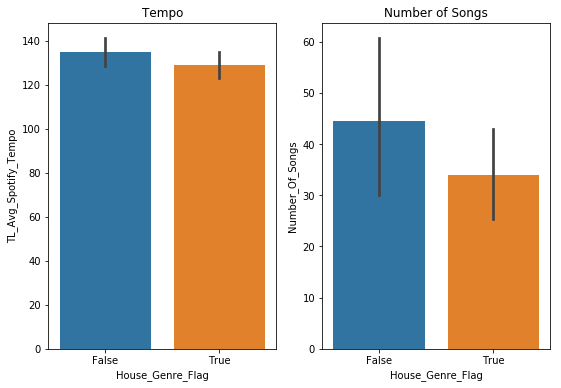

In [18]:
#Exploring Data to see if house/trance sets are different in tempo and number of songs than non-house/trance sets
fig, axes = plt.subplots(nrows = 1, ncols = 2)
fig.set_size_inches(9, 6)

#Tempo Plot
Tempo_Plot = sns.barplot(x = "House_Genre_Flag", y = "TL_Avg_Spotify_Tempo", data = QQS_DF, ax = axes[0])
axes[0].set_title("Tempo")

#Num of Songs plot
Num_Songs_Plot = sns.barplot(x = "House_Genre_Flag", y = "Number_Of_Songs", data = QQS_DF, ax = axes[1])
axes[1].set_title("Number of Songs")

House/Trance sets on average have less songs and they on average contain more tracks with slower BPMs. We'll dig into this by artist to see if this trend remains true

### Differences beteen Genres by Artist - Scatterplot EDA

In [19]:
#QQS_DF["Artist"] = 
QQS_DF["TL_Name"] = QQS_DF["TL_Name"].astype(str)
for i in QQS_DF["TL_Name"]:
    if "Ekali" in i:
        QQS_DF["Artist"] = "Ekali"
    else:
        QQS_DF["Artist"] = "Other"
        
QQS_DF["Artist"] = np.where(QQS_DF["TL_Name"].str.contains("Ekali"),"Ekali",
                    np.where(QQS_DF["TL_Name"].str.contains("Flosstradamus"),"Flosstradamus",
                    np.where(QQS_DF["TL_Name"].str.contains("JOYRYDE"),"JOYRYDE",
                    np.where(QQS_DF["TL_Name"].str.contains("San Holo"),"San Holo",
                        "Other"))))

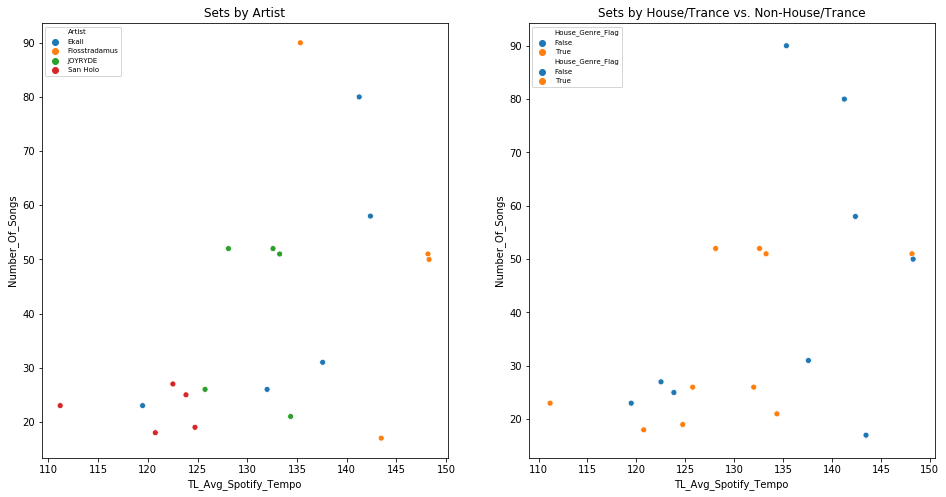

In [20]:
#Setting up Plot
fig, axes = plt.subplots(nrows = 1, ncols = 2)
fig.set_size_inches(16, 8)

#Plotting sets for tempo vs. number of songs by artist
artist_differences = sns.scatterplot(x = "TL_Avg_Spotify_Tempo", y = "Number_Of_Songs", hue = "Artist", data = QQS_DF, ax = axes[0])
axes[0].set_title("Sets by Artist")
axes[0].legend(loc = "upper left", fontsize = 7)

#Plotting sets for tempo vs. number of songs by house/trance vs. non-house/trance
house_differences = sns.scatterplot(x = "TL_Avg_Spotify_Tempo", y = "Number_Of_Songs", hue = "House_Genre_Flag", data = QQS_DF, ax = axes[1])
sns.scatterplot(x  = "TL_Avg_Spotify_Tempo", y = "Number_Of_Songs", hue = "House_Genre_Flag", data = QQS_DF, ax = axes[1])
axes[1].set_title("Sets by House/Trance vs. Non-House/Trance")
axes[1].legend(loc = "upper left", fontsize = 7)

We can see that the earlier observed trend remains true by artist: House/Trance sets on average have less songs than non-House/Trance sets and the tracks are on average slower (as shown in the chart on the top right)

The chart on the top left also shows that there seems to be a lot of variation by artist. Taking Ekali as an example, he has sets that fall within the lower left and upper right quadrants. 

With a quick google search on typical BPMs/Tempos for different genres (see below), I was able to contextualize the differences in average tempo of each set we obtained from Spotify with the differences in scraped genres(s) of each set we obtained from 1001tracklist.com. 

![title](genresPic.png)

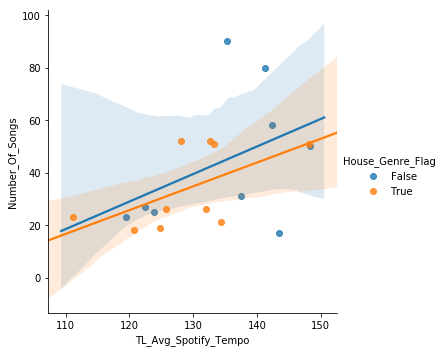

In [21]:
sns.lmplot(x = "TL_Avg_Spotify_Tempo", y = "Number_Of_Songs", hue="House_Genre_Flag", data = QQS_DF)

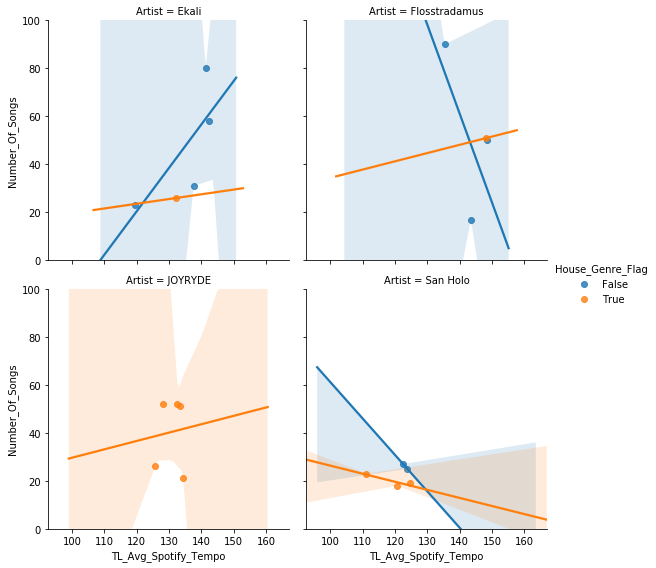

In [22]:
#Plotting Tempo vs. Number of Songs by Artist
combined_plott = sns.lmplot(x = "TL_Avg_Spotify_Tempo", y = "Number_Of_Songs", col = "Artist", hue="House_Genre_Flag", data = QQS_DF, col_wrap = 2, height = 4)
combined_plott.set(ylim=(0,100))

For the purposes of this report, I was not able to collect enough data to see if there was a linear relationship between tempo and number of songs by artist and if this varied significantly between house/trance sets vs. non-house/trance sets. 

# 2.2 Relationship between Spotify Metrics

Some other interesting metrics Spotify captures is the danceability or valence of an individual song. Each song is measured on a scale from 0 to 1 (more details on this in the diagrams below)

<table><tr>
<td> <img src="danceability.png" alt="Drawing" style="width: 350px;"/> </td>
<td> <img src="valence.png" alt="Drawing" style="width: 350px;"/> </td>
</tr></table>

We have already established that there could be a difference between genres/tempos between sets from the same artist (as shown by Ekali). Let's see if this translates into differences in danceability and valence (i.e. "mood").

### Differences between Valence/Danceability by Artist - Boxplot EDA

No handles with labels found to put in legend.
No handles with labels found to put in legend.


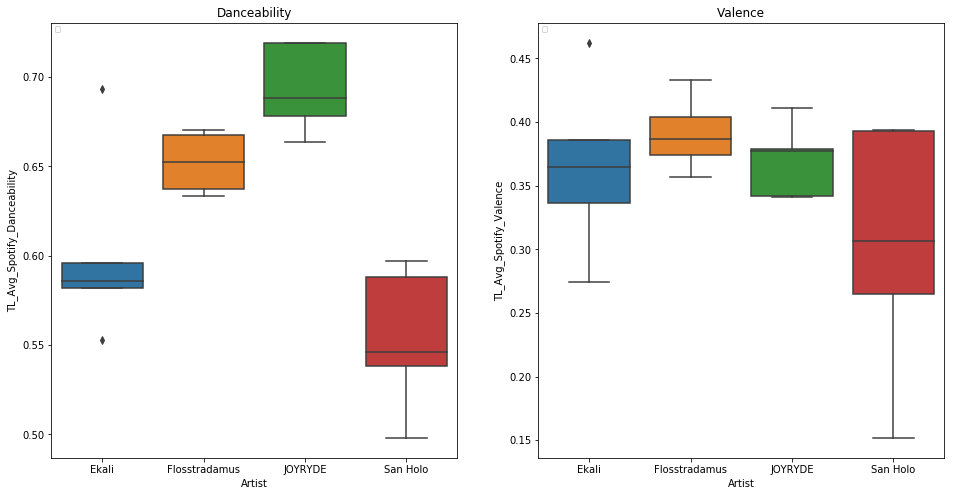

In [23]:
#Setting up Plot
fig, axes = plt.subplots(nrows = 1, ncols = 2)
fig.set_size_inches(16, 8)

#Plotting sets for tempo vs. number of songs by artist
danceability_Plot = sns.boxplot(y = "TL_Avg_Spotify_Danceability", x = "Artist", data = QQS_DF, ax = axes[0])
axes[0].set_title("Danceability")
axes[0].legend(loc = "upper left", fontsize = 7)

#Plotting sets for tempo vs. number of songs by house/trance vs. non-house/trance
Valence_Plot = sns.boxplot(y = "TL_Avg_Spotify_Valence", x = "Artist", data = QQS_DF, ax = axes[1])
axes[1].set_title("Valence")
axes[1].legend(loc = "upper left", fontsize = 7)

### Relationship between Spotify Metrics and Tempo - Pairplot Matrix and Scatterplot EDA

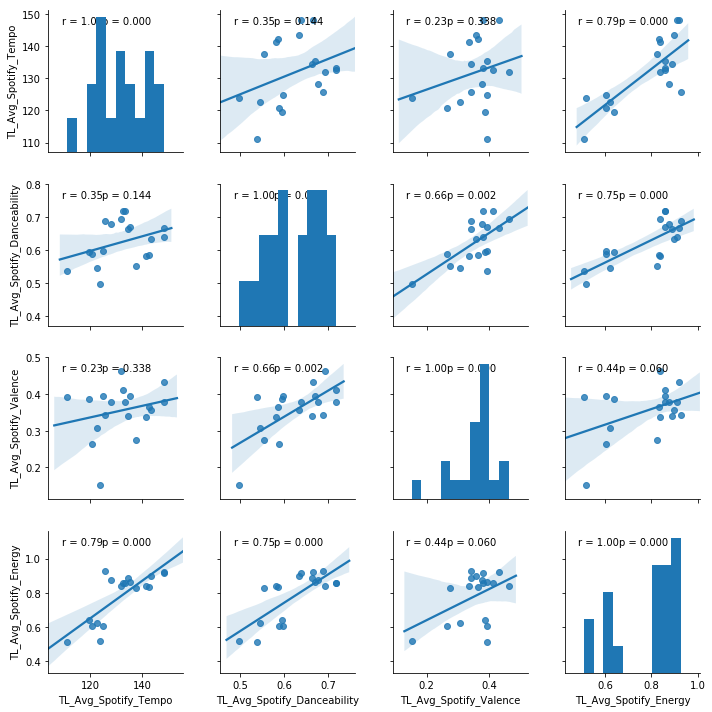

In [24]:
from scipy.stats import pearsonr
def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.4, .9), xycoords=ax.transAxes)

#corr_matrix
corr_matrix = sns.pairplot(QQS_DF, kind = "reg", vars = ["TL_Avg_Spotify_Tempo", "TL_Avg_Spotify_Danceability","TL_Avg_Spotify_Valence","TL_Avg_Spotify_Energy"])
corr_matrix.map(corrfunc)
plt.tight_layout()
plt.show()

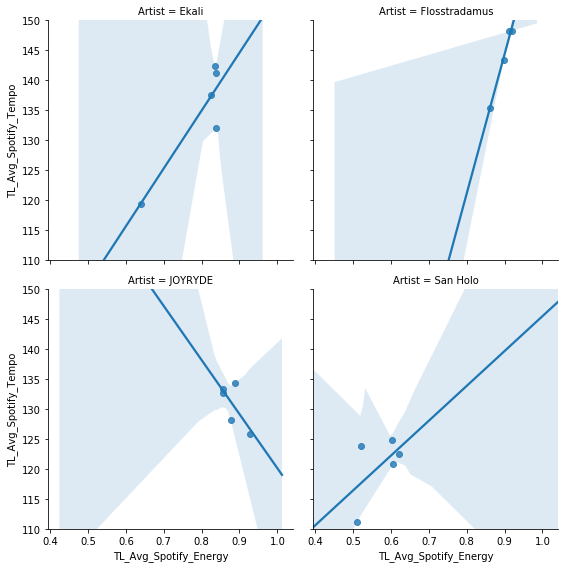

In [25]:
#Plotting Tempo vs. Energy by Artist
combined_plott = sns.lmplot(y = "TL_Avg_Spotify_Tempo", x = "TL_Avg_Spotify_Energy", col = "Artist",  data = QQS_DF, col_wrap = 2, height = 4)
combined_plott.set(ylim=(0,1))
combined_plott.set(ylim=(110,150))

There seems to be a strong relationship between danceability and energy as well as tempo and energy. However, I am not able to verify this relationship by artist as I would like to but hope to revisit this once I am able to collect more data.

### Summary of Findings

* **Differences in Number of Songs per Set and Tempo for House/Trance Sets vs. Non-House/Trance Sets:** On average, House/Trance Sets seem to have fewer songs per set as well as slower BPMs, yet more data is needed to verify this trend by artist
* **Established initial hypothesis that there are differences between sets by the same artist:** Both the danceability and mood the most recent sets played by Ekali differed significantly. This will be useful in building out our recommendation engine using a Spotify User's most recently listened to songs, saved songs, and top artists
* **Differences in Danceability and Valence by Artist:** Spotify metrics varied significantly by artist, especially for valence
* **Established a potential correlation between Energy and Tempo as well as Danceability and Energy:** More data and further statistical testing can be conducted to see if this remains true across multiple genres/artists

# 3. Recommendation Engine Building

### Using each set's metadata and associated spotify metrics to recommend a set based off my current listening habits

I hoped to build a recommendation engine using both content-based and collaborative filtering methods.

For collaborative filtering method, I hoped to use user's evaluations of recommended sets to recommend additional sets based off the user's similarity between other users. Due to the scope of this project, I was unable to collect evaluations of recommended sets to use for collaborative filtering methods and this is something I hope to revisit in the future.

![title](Collab_Filter.png)

For now, I focused on content-based filtering methods and tried to develop a score per set based on the data collected on each set.

Since my goal is to recommend a set/mix that a Spotify User will most likely like, I will try to score each set/mix based on 4 factors:
* Set's Artist Similarity to current top Artists
* Set's Song Similiarty to current top Songs and saved Songs
* Set's Overall popularity based on 1001tracklists.com
* Audio Feature Similarities between current top Songs and saved Songs with the Set's Average Audio Feature Metrics

In [26]:
#Converting spotify user's unique artists and songs into regex pattern
artist_regex_pattern = '|'.join(unique_artists)
song_regex_pattern = '|'.join(unique_songs)

In [27]:
#Creating a new column in dataframe if artist match is found in tracklist
Master_DF["New_Col_Artist_Flag"] = Master_DF["TL_SongArtist"].str.contains(artist_regex_pattern).fillna('')

#Creating a new collumn in dataframe if song match is found in tracklist
Master_DF["New_Col_Song_Flag"] = Master_DF["TL_SongName"].str.contains(song_regex_pattern).fillna('')

/anaconda2/envs/springboard/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """


In [28]:
#Creating a new Dataframe to score each set
set_order = Master_DF.groupby("TL_Name")["New_Col_Artist_Flag"].value_counts()
set_order = set_order.groupby(level = 0).apply(lambda x: x.iloc[0:1])
set_order.index = set_order.index.droplevel(0)
set_order = list(set_order.index)

#creating a list of 1s
list_of_ones = list_of_ones = [1 for i in range(len(set_order))]

SetNames = set_order
ArtistSimilarity = {"ArtistSimilarity": list_of_ones}
SongSimilarity = {"SongSimilarity": list_of_ones}
TLPopularity = {"TLPopularity": list_of_ones}
AFSimilarity = {"AFSimilarity": list_of_ones}
scoring_d = {"SetNames": set_order, "ArtistSimilarity": list_of_ones, "SongSimilarity": list_of_ones, "TLPopularity": list_of_ones, "AFSimilarity": list_of_ones}

scoring_DF = pd.DataFrame(data = scoring_d)
scoring_DF

,SetNames,ArtistSimilarity,SongSimilarity,TLPopularity,AFSimilarity
0,(Ekali & Cold Blue - Night Owl Radio 187 2019-...,1,1,1,1
1,"(Ekali - Awakening Mix #7 2019-04-16, False)",1,1,1,1
2,"(Ekali @ Beyond Wonderland 2019-03-23, False)",1,1,1,1
3,"(Ekali @ EDC Las Vegas 2019-05-19, False)",1,1,1,1
4,(Ekali @ SIAM Songkran Music Festival 2019-04-...,1,1,1,1
5,"(Flosstradamus & 4B @ Blackout Tour, Elektrici...",1,1,1,1
6,(Flosstradamus & 4B @ Spring Awakening Music F...,1,1,1,1
7,(Flosstradamus - Triple J Global Warning Mix V...,1,1,1,1
8,(Flosstradamus - Triple J Mixup Global Warning...,1,1,1,1
9,"(JOYRYDE @ Beyond Wonderland 2019-03-23, False)",1,1,1,1


# 3.1 Artist Similarity Score

In [29]:
#Creating an Artist Similarity Score
Master_DF.groupby("TL_Name")["New_Col_Artist_Flag"].value_counts()
AS = Master_DF.groupby("TL_Name")["New_Col_Artist_Flag"].sum()/Master_DF.groupby("TL_Name")["New_Col_Artist_Flag"].count()
print(AS)
AS = list(AS)

TL_Name
Ekali & Cold Blue - Night Owl Radio 187 2019-03-22                     0.000000
Ekali - Awakening Mix #7 2019-04-16                                    0.043478
Ekali @ Beyond Wonderland 2019-03-23                                   0.322581
Ekali @ EDC Las Vegas 2019-05-19                                       0.250000
Ekali @ SIAM Songkran Music Festival 2019-04-14                        0.275862
Flosstradamus & 4B @ Blackout Tour, Elektricity Michigan 2019-06-06    0.294118
Flosstradamus & 4B @ Spring Awakening Music Festival 2019-06-08        0.333333
Flosstradamus - Triple J Global Warning Mix Vol. 3 2019-06-28          0.235294
Flosstradamus - Triple J Mixup Global Warning Mix Vol. 4 2019-07-05    0.220000
JOYRYDE @ Beyond Wonderland 2019-03-23                                 0.346154
JOYRYDE @ Beyond Wonderland, United States Monterrey 2019-04-06        0.500000
JOYRYDE @ EDC Japan 2019-05-11                                         0.523810
JOYRYDE @ EDC Las Vegas 2019-05-

# 3.2 Song Similarity Score

In [30]:
#Creating a Song Similarity Score
Master_DF.groupby("TL_Name")["New_Col_Song_Flag"].value_counts()
SS = Master_DF.groupby("TL_Name")["New_Col_Song_Flag"].sum()/Master_DF.groupby("TL_Name")["New_Col_Song_Flag"].count()
print(SS)
SS = list(SS)

TL_Name
Ekali & Cold Blue - Night Owl Radio 187 2019-03-22                     0.000000
Ekali - Awakening Mix #7 2019-04-16                                    0.000000
Ekali @ Beyond Wonderland 2019-03-23                                   0.161290
Ekali @ EDC Las Vegas 2019-05-19                                       0.062500
Ekali @ SIAM Songkran Music Festival 2019-04-14                        0.086207
Flosstradamus & 4B @ Blackout Tour, Elektricity Michigan 2019-06-06    0.000000
Flosstradamus & 4B @ Spring Awakening Music Festival 2019-06-08        0.011111
Flosstradamus - Triple J Global Warning Mix Vol. 3 2019-06-28          0.000000
Flosstradamus - Triple J Mixup Global Warning Mix Vol. 4 2019-07-05    0.020000
JOYRYDE @ Beyond Wonderland 2019-03-23                                 0.000000
JOYRYDE @ Beyond Wonderland, United States Monterrey 2019-04-06        0.000000
JOYRYDE @ EDC Japan 2019-05-11                                         0.000000
JOYRYDE @ EDC Las Vegas 2019-05-

# 3.3 Set/Mix Popularity Score

In [31]:
Likes = Master_DF.groupby("TL_Name")["TL_Likes"].unique().astype(float)
Views = Master_DF.groupby("TL_Name")["TL_Views"].unique().astype(float)
PS = Likes / Views
print(PS)
PS = list(PS)

TL_Name
Ekali & Cold Blue - Night Owl Radio 187 2019-03-22                     0.001565
Ekali - Awakening Mix #7 2019-04-16                                    0.000817
Ekali @ Beyond Wonderland 2019-03-23                                   0.000000
Ekali @ EDC Las Vegas 2019-05-19                                       0.000962
Ekali @ SIAM Songkran Music Festival 2019-04-14                        0.000438
Flosstradamus & 4B @ Blackout Tour, Elektricity Michigan 2019-06-06    0.000000
Flosstradamus & 4B @ Spring Awakening Music Festival 2019-06-08        0.001538
Flosstradamus - Triple J Global Warning Mix Vol. 3 2019-06-28          0.001267
Flosstradamus - Triple J Mixup Global Warning Mix Vol. 4 2019-07-05    0.001508
JOYRYDE @ Beyond Wonderland 2019-03-23                                 0.000000
JOYRYDE @ Beyond Wonderland, United States Monterrey 2019-04-06        0.000000
JOYRYDE @ EDC Japan 2019-05-11                                         0.001332
JOYRYDE @ EDC Las Vegas 2019-05-

# 3.4 Audio Feature Similarity Score

In [32]:
#My Personal Spotify Data
print(songFeatures_DF.describe())

       acousticness  danceability     energy  instrumentalness        key  \
count     47.000000     47.000000  47.000000         47.000000  47.000000   
mean       0.161437      0.628787   0.666894          0.253670   6.404255   
std        0.214941      0.106264   0.177500          0.349127   3.609526   
min        0.001140      0.411000   0.272000          0.000000   0.000000   
25%        0.019700      0.566000   0.562000          0.000002   4.000000   
50%        0.062400      0.624000   0.696000          0.002340   7.000000   
75%        0.221000      0.703000   0.763500          0.522500   9.000000   
max        0.881000      0.876000   0.994000          0.943000  11.000000   

        loudness       mode       tempo  time_signature    valence  
count  47.000000  47.000000   47.000000       47.000000  47.000000  
mean   -6.765894   0.446809  122.198021        3.978723   0.314823  
std     2.505313   0.502538   28.486329        0.145865   0.212389  
min   -12.928000   0.000000   

In [33]:
#Looking at just Danceability and Valence
MyCurrentDanceability = songFeatures_DF["danceability"].mean()
MyCurrentMood = songFeatures_DF["valence"].mean()

#Grabbing average danceability and valence from spotify x 1001tracklist data
avg_set_danceability = list(Good_Quality_Sets.groupby("TL_Name")["TL_Avg_Spotify_Danceability"].unique())
avg_set_mood = list(Good_Quality_Sets.groupby("TL_Name")["TL_Avg_Spotify_Valence"].unique())

In [34]:
#Initializing diff in means array
diff_means_danceability = []
diff_means_mood = []

#Calculating abs difference from mean from each quality set
for set in avg_set_danceability:
    diff_means_danceability.append(abs(MyCurrentDanceability - float(set)))
#repeat for mood    
for set in avg_set_mood:
    diff_means_mood.append(abs(MyCurrentMood - float(set)))

In [35]:
#Printing my dif in means between each set and my avg danceability and mood 
print(diff_means_danceability)
print(diff_means_mood)

[0.06426539753639404, 0.03295390070922011, 0.07592056737588682, 0.04709675785207712, 0.0431443768996963, 0.00461276595744653, 0.04178723404255302, 0.009739081746920175, 0.037323877068557554, 0.09003629536921132, 0.05937943262411327, 0.03494609929077985, 0.04918050789293038, 0.09039225313693366, 0.13092056737588675, 0.09062056737588675, 0.032018003273322715, 0.040787234042553466, 0.08302723404255352]
[0.14745554311310205, 0.07120159574468082, 0.04075007092198579, 0.021450405268490513, 0.04988731003039515, 0.04230326241134752, 0.07904255319148945, 0.06455027995520712, 0.11793770685579191, 0.0961765957446809, 0.027343262411347602, 0.026176595744680953, 0.06274111187371312, 0.06410992907801422, 0.16311007092198568, 0.07834326241134765, 0.07917659574468094, 0.049673404255319076, 0.008195404255319061]


In [36]:
AF_weight = []
for i in range(len(set_order)):
    AF_weight.append((diff_means_danceability[i] + diff_means_mood[i]) / 2)
print(AF_weight)

[0.10586047032474805, 0.052077748226950465, 0.058335319148936304, 0.03427358156028382, 0.046515843465045725, 0.023458014184397025, 0.06041489361702124, 0.03714468085106365, 0.07763079196217473, 0.09310644555694611, 0.043361347517730436, 0.030561347517730403, 0.05596080988332175, 0.07725109110747394, 0.14701531914893623, 0.0844819148936172, 0.05559729950900183, 0.04523031914893627, 0.04561131914893629]


# 3.5 Final Recommendation

In [37]:
final_rec = scoring_DF
final_rec["ArtistSimilarity"] = final_rec["ArtistSimilarity"] * AS
final_rec["SongSimilarity"] = final_rec["SongSimilarity"] * SS
final_rec["TLPopularity"] = final_rec["TLPopularity"] * PS
final_rec["AFSimilarity"] = final_rec["AFSimilarity"] * AF_weight

In [38]:
final_rec["Overall_Score"] = final_rec["ArtistSimilarity"] + final_rec["SongSimilarity"] + final_rec["TLPopularity"] + final_rec["ArtistSimilarity"]

In [39]:
final_rec

,SetNames,ArtistSimilarity,SongSimilarity,TLPopularity,AFSimilarity,Overall_Score
0,(Ekali & Cold Blue - Night Owl Radio 187 2019-...,0.000000,0.000000,0.001565,0.105860,0.001565
1,"(Ekali - Awakening Mix #7 2019-04-16, False)",0.043478,0.000000,0.000817,0.052078,0.087774
2,"(Ekali @ Beyond Wonderland 2019-03-23, False)",0.322581,0.161290,0.000000,0.058335,0.806452
3,"(Ekali @ EDC Las Vegas 2019-05-19, False)",0.250000,0.062500,0.000962,0.034274,0.563462
4,(Ekali @ SIAM Songkran Music Festival 2019-04-...,0.275862,0.086207,0.000438,0.046516,0.638369
5,"(Flosstradamus & 4B @ Blackout Tour, Elektrici...",0.294118,0.000000,0.000000,0.023458,0.588235
6,(Flosstradamus & 4B @ Spring Awakening Music F...,0.333333,0.011111,0.001538,0.060415,0.679316
7,(Flosstradamus - Triple J Global Warning Mix V...,0.235294,0.000000,0.001267,0.037145,0.471856
8,(Flosstradamus - Triple J Mixup Global Warning...,0.220000,0.020000,0.001508,0.077631,0.461508
9,"(JOYRYDE @ Beyond Wonderland 2019-03-23, False)",0.346154,0.000000,0.000000,0.093106,0.692308


In [40]:
final_rec.iloc[final_rec["Overall_Score"].idxmax()]

SetNames            (San Holo @ redrocks1, Red Rocks Amphitheatre ...
ArtistSimilarity                                                    1
SongSimilarity                                                      0
TLPopularity                                               0.00244898
AFSimilarity                                                0.0456113
Overall_Score                                                 2.00245
Name: 18, dtype: object

# 4. Conclusion

# 4.1 Results and Next Steps

## Results

The recommendation system returned all sets with varying scores based off my current listening habits (taken from my personal Spotify data), with the highest-scoring set being returned as the recommended set to listen to. In this case, a set by San Holo at Red Rocks seems to be the most aligned with my current listening habits on Spotify.

Ideally, I would have wanted to come up with an evaluation system for for users to test out my recommendation system. The evaluation metrics could then be used to fine-tune my scoring algorithm or be used as inputs for a social collaborative filtering method. 

For the scope of this project, I was unable to collect enough data due to the amount of time and effort it would have required to understand the nuances of the website in which the data was stored. With more time, I hope to implement additional features to my web scraper to more efficiently and more accurately collect data on each set/mix.

## Next Steps

With more time, I hope to implement the following:
* **Web Scraper Optimization - Broken Spotify Links**: The spotify objects on each page were not always 100% complete. As 1001tracklists.com is a website updated manually by users, it could have been the case that some individual songs had no Spotify links at all despite the same song having a working Spotify link on a different webpage. With more time, I hope to locally cache working Spotify links with their corresponding song and artist name as a key - value pair that I could then use to fill some of the gaps on some of the webpages
* **Web Scraper Optimization - Unstandardized HTML**: Another pitfall that I didn't initially account for that proved to be too time-consuming to overcome was the lack of uniformity amongst each webpage. As you can see in the screenshot below, the Spotify objects are located in a class called "mediaDiv center" with the id "tlp_4141142_player". Sometimes, these classes were labelled differently on different webpages. Even more challenging was trying to use Selenium to automate the clicking of these objects. Spotify trackid is only available upon "clicking" the Spotify object which then loads an iframe. Sometimes, these iframes wouldn't even load at all despite the Spotify Object showing up as green. More time would have been needed to improve my automated webscraper to overcome these challeneges and I hope to revisit this outside of the Capstone 2 Project to create a more robust dataset to feed into my recommendation system.
* **Web Scraper Optimization - Cache Artist Data**: Most challenging of all was trying to build my automated web scraper in a way so that I wouldn't get banned each time I ran my scripts. Trying to find the optimal wait time between each click proved to be frustrating yet with more time I could implement wait conditions that other people have documented on various resources online to avoid being banned and collect a good amount of data

![title](pitfalls.png)

Because of the aforementioned challenges, the data I collected varied in accuracy and I was not able to collect enough data as I would have liked to properly output a good list of recommendations for users to evaluate. Below is an example of how certain sets lacked all data, making it impossible to include some of the more critical inputs to my recommendation system.

![title](ExcelSS.png)

Lastly, as mentioned before, I hope to create an evaluation system so users who do use my recommendation system can score each set that they are recommended.

My hope is to output 5 sets/mixes to users who would then rank each set from 1-5. After collecting these user's scores, I would like to use that data to fine-tune my scoring method in the recommendation algorithm.